<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 3 - Aplicaciones de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Modelos Generativos profundos: VAE (*Variational Autoencoder*) y GAN (*Generative Adversarial Network*).
* Arquitectura encoder-decoder y mecanismo de antención.
* Desafío en donde se aplique todo lo aprendido.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: -
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Modelos Generativos  
[2.](#segundo) *Question-Answering*  
[3.](#tercer) Challenge (*Object Counting*)

*Nota: Para esta actividad, al igual que anteriores, si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*

<a id="tercero"></a>
## 3. Challenge: Crowd (Object) Counting

<img src="http://personal.ie.cuhk.edu.hk/~ccloy/images/shopping_mall_annotated.jpg" title="Crowd Counting" width="30%"/>

Para esta sección final se evaluará todo lo que han aprendido a través de un desafío en donde puedan competir y medir sus resultados *in time* en la plataforma de __[Kaggle](https://www.kaggle.com/)__. El problema y todo su detalle puede ser encontrado en la página de la competencia a través del siguiente link:


<center><H2> __[Competencia Object Counting](https://www.kaggle.com/t/59c93ca0e8ae47999f9287a5751d6402)__ </H2></center>



Para esto deberán crearse una cuenta en la plataforma *Kaggle* y subir sus respuestas a ésta. Por favor crearse nombres que sean fácil identificar después para saber quién fue quién, sino no podrán tener la nota (o en el correo de entrega ponen cual es su nombre de usuario en la competencia).

*Nota: El puntaje que entregará al estar participando en la competencia (menos de 2 puntos al *benchmark* que se presenta) y el lugar obtenido se presenta en la página de Kaggle.*

> Las entregas en *csv* pueden ser generadas de la siguiente manera:
```python
import pandas as pd
d = {'id': test_ids, 'count': prediction_test}
entrega = pd.DataFrame(data=d,columns=['id','count'])
entrega.to_csv('mysubmission.csv', index=False)
```

> Los archivos binarios de numpy pueden ser cargados facilmente con el siguiente comando:
```python
import numpy as np
dato = np.load('binary_file.npy')
```

> Las imagenes en python pueden ser cargadas con la librería Pillow y transformadas a numpy array con el siguiente comando:
```python
from PIL import Image
img = Image.open("path/to/image.jpg or png")
np.asarray(img)
```

In [1]:
import pandas as pd
from PIL import Image

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, rmsprop
from keras.callbacks import LearningRateScheduler
import math
import matplotlib.pyplot as plt
%matplotlib inline

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
##Cargar Datos
import os
script_dir = os.path.dirname("Pregunta 3.ipynb")  # Script directory
full_path_labels_train = os.path.join(script_dir, '../Datos 3/labels_train.csv')
full_path_images_train = os.path.join(script_dir, '../Datos 3/images_train.npy')
full_path_images_test = os.path.join(script_dir, '../Datos 3/images_test.npy')

#ENTRADAS
x_train = np.load(full_path_images_train)
x_test = np.load(full_path_images_test)
print(x_train.shape)
img_rows, img_cols, channel = x_train.shape[1:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#SALIDAS
df_labels_train = pd.read_csv(full_path_labels_train)
df_labels_train = df_labels_train.sort_values(by=['id'])
print(df_labels_train.shape)
df_labels_train.head()
y_train=df_labels_train['count']

(1600, 480, 640, 3)
(1600, 2)


In [47]:
df_labels_train.head()

,id,count
0,401,29
1,402,30
2,403,31
3,404,26
4,405,26


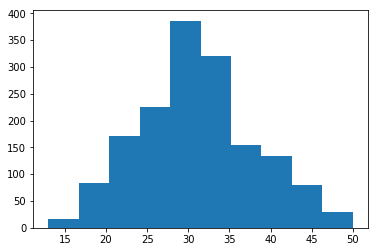

In [37]:
plt.hist(y_train)
plt.show()

In [42]:
print(x_test[0])

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.5882353  0.4627451  0.37254903]
  [0.5921569  0.46666667 0.3764706 ]
  [0.5921569  0.46666667 0.3764706 ]
  ...
  [0.7882353  0.6117647  0.4509804 ]
  [0.8        0.62352943 0.45882353]
  [0.8039216  0.6313726  0.45490196]]

 [[0.59607846 0.47058824 0.38039216]
  [0.59607846 0.47058824 0.38039216]


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  app.launch_new_instance()


29
(196, 262, 3)


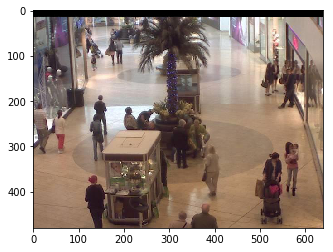

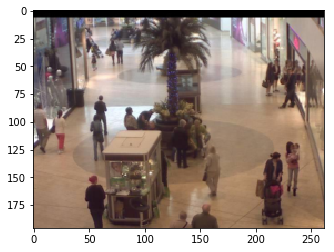

In [19]:
from scipy.misc import imresize
imagen = x_train[0]
small = imresize(imagen,0.41)
print(y_train[0])
print (small.shape)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#image = mpimg.imread("chelsea-the-cat.png")
plt.imshow(imagen)
plt.show()
plt.imshow(small)
plt.show()

In [21]:
from scipy.misc import imresize
x_train_r = []
for i in range(len(x_train)):
    x_train_r.append(imresize(x_train[i],0.41))
x_train_r = np.asarray(x_train_r)
print(x_train_r.shape)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(1600, 196, 262, 3)


In [54]:
from keras.layers import BatchNormalization 
from keras.optimizers import Adadelta
from keras.regularizers import *
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 


opt = Adadelta()
#opt = rmsprop()
##Data augmentation
##transfer learning AlexNet - BGG
model = Sequential()
model.add(Conv2D(128, (10, 10), padding='same', input_shape=x_train_r.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dense(100,W_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer=opt,loss=root_mean_squared_error)
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 196, 262, 128)     38528     
_________________________________________________________________
activation_60 (Activation)   (None, 196, 262, 128)     0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 196, 262, 128)     409728    
_________________________________________________________________
activation_61 (Activation)   (None, 196, 262, 128)     0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 98, 131, 64)       73792     
_________________________________________________________________
activation_62 (Activation)   (None, 98, 131, 64)       0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 49, 65, 64)        0         
__________

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_regularizer=<keras.reg...)`


In [ ]:
batch_size = 10
epochs = 25
history = model.fit(x_train_r, y_train,epochs=epochs,batch_size=batch_size, validation_split=0.2,shuffle=True)
#model.save_weights('modelo-p3-1.h5')

Train on 1280 samples, validate on 320 samples
Epoch 1/25
1280/1280 [==============================] - 59s 46ms/step - loss: 13.0138 - val_loss: 6.5293
Epoch 2/25
1280/1280 [==============================] - 56s 44ms/step - loss: 7.8505 - val_loss: 14.5086
Epoch 3/25
 360/1280 [=======>......................] - ETA: 36s - loss: 7.2906

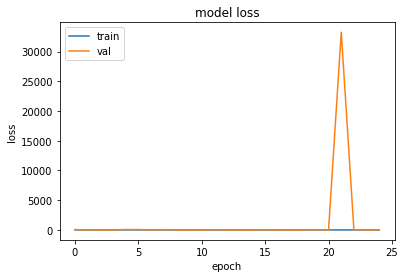

In [30]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [31]:
from scipy.misc import imresize
x_test_r = []
for i in range(len(x_test)):
    x_test_r.append(imresize(x_test[i],0.41))
x_test_r = np.asarray(x_test_r)
print(x_test_r.shape)

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(400, 196, 262, 3)


In [33]:
prediction_test = model.predict(x_test_r,batch_size=batch_size,verbose=1)

400/400 [==============================] - 7s 16ms/step


[41. 47. 47. 43. 50. 51. 41. 43. 36. 35.]


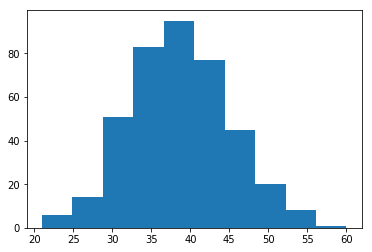

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [50]:
for i in range(400):
    prediction_test[i] =np.int(prediction_test[i])
print(prediction_test[:10])
plt.hist(prediction_test)
plt.show()
prediction_test = np.reshape(prediction_test,[400,])
prediction_test= prediction_test.astype("int")
prediction_test = np.asarray(prediction_test)
test_ids=np.arange(1,401)
print(test_ids)

In [51]:
import pandas as pd

d = {'id': test_ids, 'count': prediction_test}
entrega = pd.DataFrame(data=d,columns=['id','count'])
entrega.to_csv('mysubmission.csv', index=False)

In [52]:
df_subs = pd.read_csv('mysubmission.csv')
df_subs.head()

,id,count
0,1,41.0
1,2,47.0
2,3,47.0
3,4,43.0
4,5,50.0


In [24]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely



,id,count
1595,1996,27
1596,1997,27
1597,1998,25
1598,1999,26
1599,2000,26
